# Answer the questions
### For which of the models already studied is the curse of dimensionality relevant and explain why?
The curse of dimensionality refers to phenomena affecting statistical and machine learning models when working with high-dimensional spaces. Some key effects include increased sparsity, need for exponentially more training examples, and degraded performance unless carefully handled. Models impacted include:
Nearest Neighbors Algorithms (KNN): As dimension increases, Euclidean distances become less informative, diminishing effectiveness
Decision Trees / Random Forests: Splitting decisions rely heavily on axis-aligned splits; higher dimensions introduce irrelevant features, complicating decision boundaries
SVM with RBF Kernel: High-dimensional inputs cause kernel computations to grow exponentially, slowing down training
Linear Regression / Logistic Regression: Increased likelihood of multicollinearity and potential overfitting due to sparsely populated feature space
### What is the difference between PCA and SVD?
PCA (Principal Component Analysis) and SVD (Singular Value Decomposition) are closely connected but serve different purposes. PCA is specifically designed to identify the directions of maximum variance in the data and acts as a dimensionality-reduction tool. On the other hand, SVD is a general-purpose matrix factorization technique with broad applicability—not limited to dimensionality reduction alone. Even though PCA often utilizes SVD internally for computing eigenvalues and eigenvectors, their ultimate goals remain distinct.
### What is the difference between NMF and SVD?
The primary distinction lies in the constraints imposed on the output matrices. NMF (Non-negative Matrix Factorization) enforces non-negativity on the factorized matrices, enabling the extraction of interpretable components suited for analyzing real-world data such as texts or images. By contrast, SVD does not constrain the signs of intermediate matrix elements, allowing wider applicability in contexts where negative values are permissible.
### Describe the structure of the Locally Linear Embedding dimension reduction algorithm?
Locally Linear Embedding (LLE) was developed to overcome shortcomings of traditional linear methods like PCA when dealing with nonlinear manifolds. At its heart, LLE first identifies neighboring points for each data instance. Then, it calculates reconstruction weights reflecting contributions from neighboring points towards reproducing the original point. Next, an optimization problem is solved to map the points into a lower-dimensional space while preserving the relations among neighbors. Finally, the lowest eigenvalues' eigenvectors provide a compact representation that retains essential topological properties of the initial dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [54]:
import os
import cv2
import time
import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import xgboost as xgb
import catboost as cat
import tensorflow as tf
from scipy.io import arff
from umap.umap_ import UMAP
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from scipy.sparse import csr_matrix
from scipy.stats import uniform, randint
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE, LocallyLinearEmbedding
from sklearn.preprocessing import MaxAbsScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier, LinearRegression
from sklearn.metrics import accuracy_score, f1_score, silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Classification with Sparse Features

In [4]:
def load_data(ratings_path, users_path):
    ratings = pd.read_csv(ratings_path)
    users = pd.read_csv(users_path)

    user_counts = ratings['User-ID'].value_counts()
    active_users = user_counts[user_counts >= 20].index
    ratings = ratings[ratings['User-ID'].isin(active_users)]

    book_counts = ratings['ISBN'].value_counts()
    popular_books = book_counts[book_counts >= 20].index
    ratings = ratings[ratings['ISBN'].isin(popular_books)]

    data = ratings.merge(users, on='User-ID')

    data = data.dropna(subset=['Age'])
    data['age_category'] = pd.cut(data['Age'], bins=[0, 25, 30, 50, 100], labels=['teen', 'grown', 'middle', 'mature'])
    data = data.dropna(subset=['age_category'])

    return data

data = load_data('/content/drive/MyDrive/data/bookRecommendationDataset/Ratings.csv', '/content/drive/MyDrive/data/bookRecommendationDataset/Users.csv')
data.head()

User-ID        ISBN  Book-Rating                                Location  \
0   276762  0380711524            5  duisburg, nordrhein-westfalen, germany   
1   276762  0451167317            0  duisburg, nordrhein-westfalen, germany   
2   276847  0446364193            0      köln, nordrhein-westfalen, germany   
3   276847  3426029553            8      köln, nordrhein-westfalen, germany   
4   276925  002542730X           10             barcelona, barcelona, spain   

    Age age_category  
0  25.0         teen  
1  25.0         teen  
2  27.0        grown  
3  27.0        grown  
4  22.0         teen

In [5]:
def data_info(df):
    print("Shape:", df.shape)
    print()
    display(df.sample(10))
    print()
    print("Info:")
    df.info()
    print()
    print("Statistics:")
    display(df.describe())
    print()
    print("Missing:")
    display(pd.DataFrame({'% missing values':df.isna().mean()}))
    print()
    print("Duplicates:", df.duplicated().sum())

In [6]:
data_info(data)

Shape: (195590, 6)



User-ID        ISBN  Book-Rating                          Location  \
252999   269321  051513628X            9       walpole, massachusetts, usa   
122499   130474  0440220602            0         nashville, tennessee, usa   
102191   110440  0440223202           10            fairfax, virginia, usa   
65396     69697  0312979983            0  west sacramento, california, usa   
75275     79186  0446606324            0            fairbanks, alaska, usa   
234810   249146  000649840X            0           algés, lisboa, portugal   
240266   254481  0345368932            0          gallatin, tennessee, usa   
23501     25409  0452283795            0          la mesa, california, usa   
153557   165308  0312278586            0        new berlin, wisconsin, usa   
60961     63625  0553287737           10         torrance, california, usa   

         Age age_category  
252999  49.0       middle  
122499  33.0       middle  
102191  29.0        grown  
65396   24.0         teen  
75275   37.0       middle  
234810  41.0       middle  
240266  25.0         teen  
23501   31.0       middle  
153557  33.0       middle  
60961   15.0         teen


Info:
<class 'pandas.core.frame.DataFrame'>
Index: 195590 entries, 0 to 259445
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   User-ID       195590 non-null  int64   
 1   ISBN          195590 non-null  object  
 2   Book-Rating   195590 non-null  int64   
 3   Location      195590 non-null  object  
 4   Age           195590 non-null  float64 
 5   age_category  195590 non-null  category
dtypes: category(1), float64(1), int64(2), object(2)
memory usage: 9.1+ MB

Statistics:


User-ID    Book-Rating            Age
count  195590.000000  195590.000000  195590.000000
mean   141768.583205       2.491334      36.656475
std     78951.084776       3.810356      11.460631
min       242.000000       0.000000       1.000000
25%     75860.000000       0.000000      28.000000
50%    141493.000000       0.000000      35.000000
75%    209756.000000       7.000000      44.000000
max    278851.000000      10.000000     100.000000


Missing:


% missing values
User-ID                    0.0
ISBN                       0.0
Book-Rating                0.0
Location                   0.0
Age                        0.0
age_category               0.0


Duplicates: 0


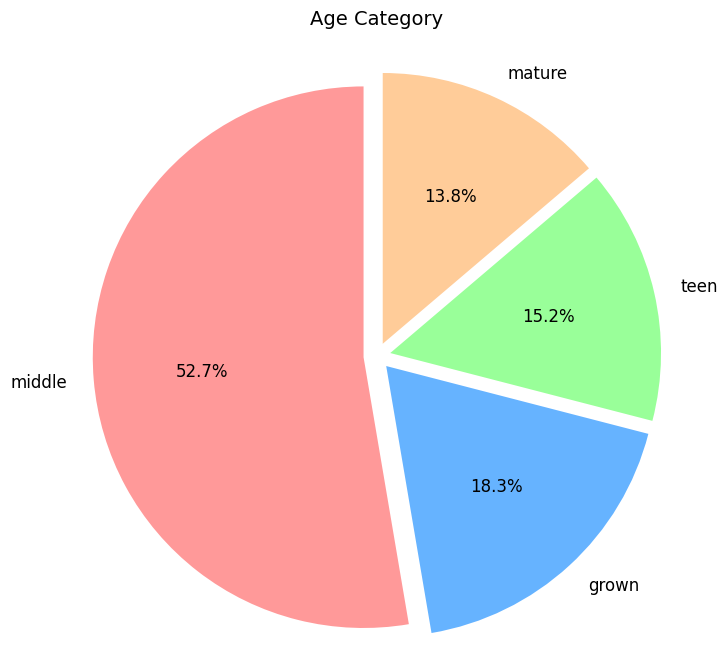

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))

class_counts = data['age_category'].value_counts()
labels = class_counts.index
sizes = class_counts.values

ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90,
       colors=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'],
       textprops={'fontsize': 12}, explode=[0.05] * len(labels))

ax.set_title('Age Category', fontsize=14, pad=15)
plt.axis('equal')

plt.show()

In [8]:
le = LabelEncoder()
data['age_category'] = le.fit_transform(data['age_category'])

In [9]:
def create_sparse_matrix(data):
    data['user_code'] = data['User-ID'].astype('category').cat.codes
    data['book_code'] = data['ISBN'].astype('category').cat.codes

    sparse_matrix = csr_matrix((data['Book-Rating'], (data['user_code'], data['book_code'])))

    user_mapping = dict(zip(data['user_code'], data['User-ID']))
    user_ids = data[['User-ID', 'user_code']].drop_duplicates().set_index('user_code')['User-ID']

    return sparse_matrix, user_mapping, user_ids

X, user_mapping, user_ids = create_sparse_matrix(data)

y = data.groupby('User-ID')['age_category'].first().reindex(user_ids.values).values

In [10]:
def split_data(X, y, test_size=0.2, valid_size=0.2):
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42)
    valid_size_adjusted = valid_size / (1 - test_size)
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_temp, y_temp, test_size=valid_size_adjusted, random_state=42)

    scaler = MaxAbsScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    X_test = scaler.transform(X_test)

    return X_train, X_valid, X_test, y_train, y_valid, y_test

X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(X, y)

In [11]:
pca = PCA(n_components=40, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

umap_reducer = UMAP(n_components=40, random_state=42)
X_train_umap = umap_reducer.fit_transform(X_train)
X_val_umap = umap_reducer.transform(X_valid)
X_test_umap = umap_reducer.transform(X_test)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [14]:
models = {
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=10000, random_state=42),
        'params': {'C': uniform(0.1, 10), 'solver': ['saga', 'lbfgs', 'liblinear']}
    },
    'SGDClassifier': {
        'model': SGDClassifier(max_iter=10000, random_state=42),
        'params': {'alpha': uniform(0.0001, 0.01), 'loss': ['hinge', 'log_loss'], 'penalty': ['l2', 'l1']}
    },
    'LinearSVC': {
        'model': LinearSVC(random_state=42, max_iter=10000),
        'params': {'C': uniform(0.1, 10)}
    },
        'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {'n_estimators': randint(100, 300), 'max_depth': [10, 20, None], 'min_samples_split': randint(2, 10)}
    },
    'XGBClassifier': {
        'model': xgb.XGBClassifier(random_state=42, eval_metric='mlogloss'),
        'params': {'n_estimators': randint(100, 300), 'max_depth': randint(3, 10), 'learning_rate': uniform(0.01, 0.2)}
    },
}

In [16]:
results = []
for name, config in models.items():
    print(f'Start {name}')
    for feature_set, X_tr, X_v, X_te in [
        ('Original', X_train, X_valid, X_test),
        ('PCA', X_train_pca, X_val_pca, X_test_pca),
        ('UMAP', X_train_umap, X_val_umap, X_test_umap)
    ]:
        search = RandomizedSearchCV(
            config['model'],
            config['params'],
            n_iter=10,
            cv=3,
            scoring='accuracy',
            n_jobs=-1,
            random_state=42
        )
        search.fit(X_tr, y_train)
        best_model = search.best_estimator_

        start_time = time.time()
        best_model.fit(X_tr, y_train)
        y_pred = best_model.predict(X_te)
        fit_time = time.time() - start_time

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')

        results.append([name, feature_set, accuracy, f1, fit_time])

Start LogisticRegression
Start SGDClassifier
Start LinearSVC
Start RandomForest
Start XGBClassifier


In [17]:
headers = ['Model', 'Features Set', 'Accuracy', 'F1', 'Fit Time (s)']
results_df = pd.DataFrame(results, columns=headers)
results_df

Model Features Set  Accuracy        F1  Fit Time (s)
0   LogisticRegression     Original  0.465451  0.206970      0.827529
1   LogisticRegression          PCA  0.486564  0.163760      0.025843
2   LogisticRegression         UMAP  0.491363  0.169087      0.720456
3        SGDClassifier     Original  0.489443  0.164304      0.055552
4        SGDClassifier          PCA  0.489443  0.164304      0.049515
5        SGDClassifier         UMAP  0.489443  0.164304      0.069884
6            LinearSVC     Original  0.399232  0.264422      0.053228
7            LinearSVC          PCA  0.485605  0.163648      0.049173
8            LinearSVC         UMAP  0.491363  0.169280      0.140011
9         RandomForest     Original  0.490403  0.166768      0.606177
10        RandomForest          PCA  0.485605  0.166526      2.135602
11        RandomForest         UMAP  0.490403  0.166961      3.027958
12       XGBClassifier     Original  0.490403  0.172402      3.433107
13       XGBClassifier          PCA  0.486564  0.168936      0.926191
14       XGBClassifier         UMAP  0.490403  0.166758      0.763779

# Visualizations

In [18]:
data, meta = arff.loadarff('/content/drive/MyDrive/data/mnist/mnist_784.arff')
df = pd.DataFrame(data)
X = df.drop(columns=['class']).values
y = df['class'].astype(str).astype(int)

In [19]:
np.random.seed(42)
sample_size = 20000
indices = np.random.choice(X.shape[0], sample_size, replace=False)
X = X[indices]
y = y[indices]

In [20]:
methods = {
    'PCA': PCA(n_components=2, random_state=42, whiten=True),
    'SVD': TruncatedSVD(n_components=2, random_state=42, n_iter=15),
    'Randomized SVD': TruncatedSVD(n_components=2, random_state=42, algorithm='randomized', n_iter=15),
    't-SNE': TSNE(n_components=2, random_state=42, perplexity=50, n_iter=2000, learning_rate=200),
    'UMAP': UMAP(n_components=2, random_state=42, n_neighbors=50, min_dist=0.001, metric='manhattan'),
    'LLE': LocallyLinearEmbedding(n_components=2, random_state=42, n_neighbors=50, method='modified')
}

results = {}
metrics = {'Silhouette': [], 'Davies-Bouldin': [], 'Calinski-Harabasz': []}

In [21]:
def apply_and_visualize(name, model, X, y, results, metrics):
    X_2d = model.fit_transform(X)
    results[name] = X_2d

    if isinstance(model, UMAP):
        joblib.dump(model, 'umap_model.pkl')
        print(f"Модель {name} save as umap_model.pkl")

    silhouette = silhouette_score(X_2d, y)
    db = davies_bouldin_score(X_2d, y)
    ch = calinski_harabasz_score(X_2d, y)

    metrics['Silhouette'].append(silhouette)
    metrics['Davies-Bouldin'].append(db)
    metrics['Calinski-Harabasz'].append(ch)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='tab10', s=10)
    plt.title(f'{name}\nSilhouette: {silhouette:.3f}, DB: {db:.3f}, CH: {ch:.0f}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(scatter, label='Digit')
    plt.tight_layout()
    plt.show()

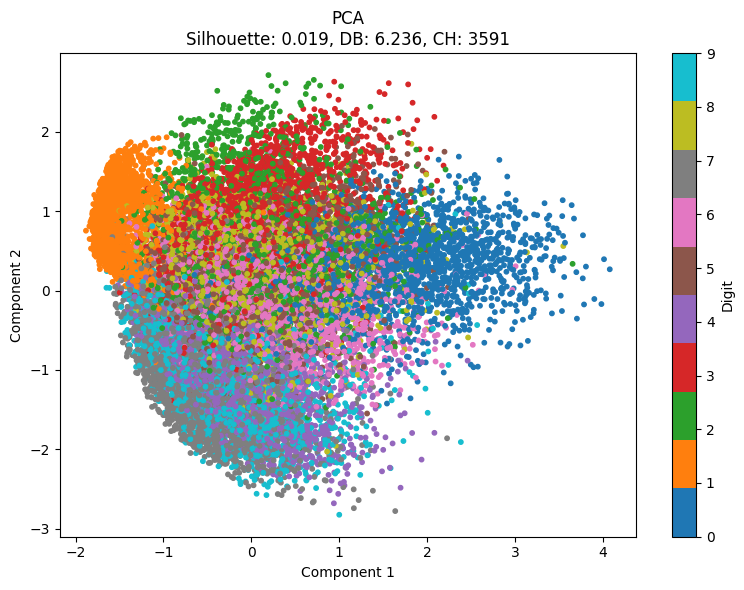

In [22]:
apply_and_visualize('PCA', methods['PCA'], X, y, results, metrics)

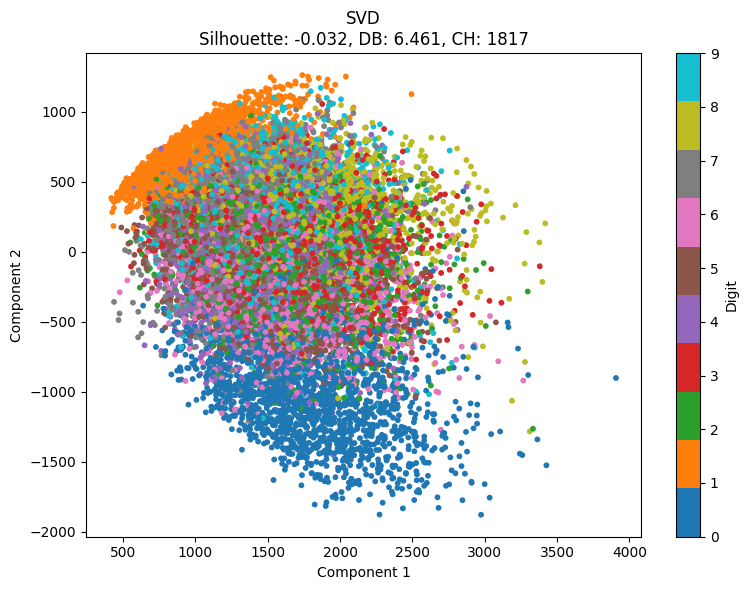

In [23]:
apply_and_visualize('SVD', methods['SVD'], X, y, results, metrics)

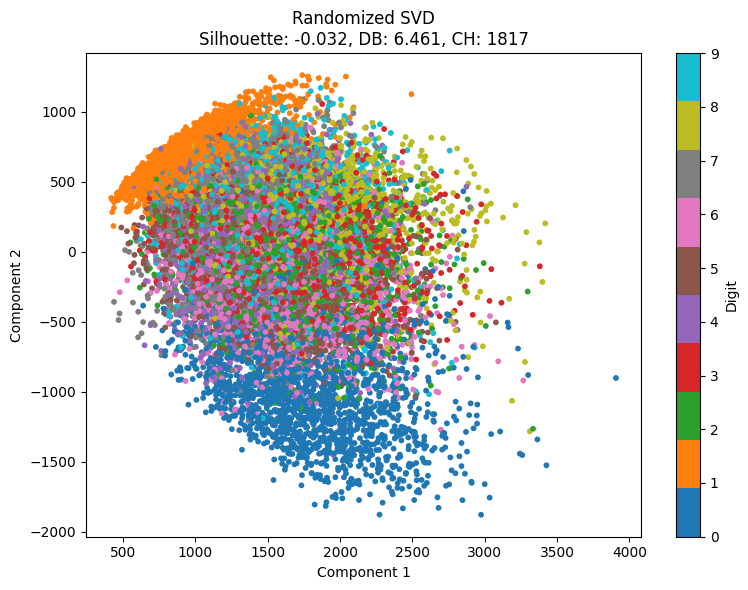

In [24]:
apply_and_visualize('Randomized SVD', methods['Randomized SVD'], X, y, results, metrics)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


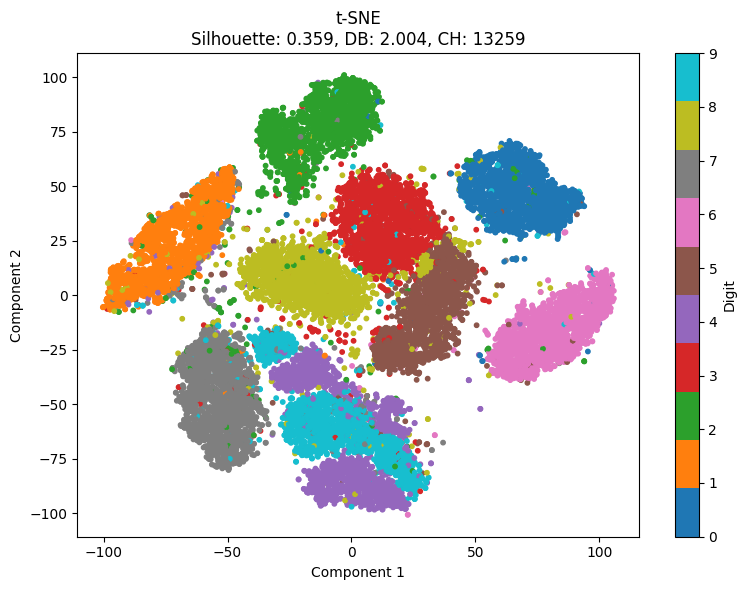

In [25]:
apply_and_visualize('t-SNE', methods['t-SNE'], X, y, results, metrics)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Модель UMAP save as umap_model.pkl


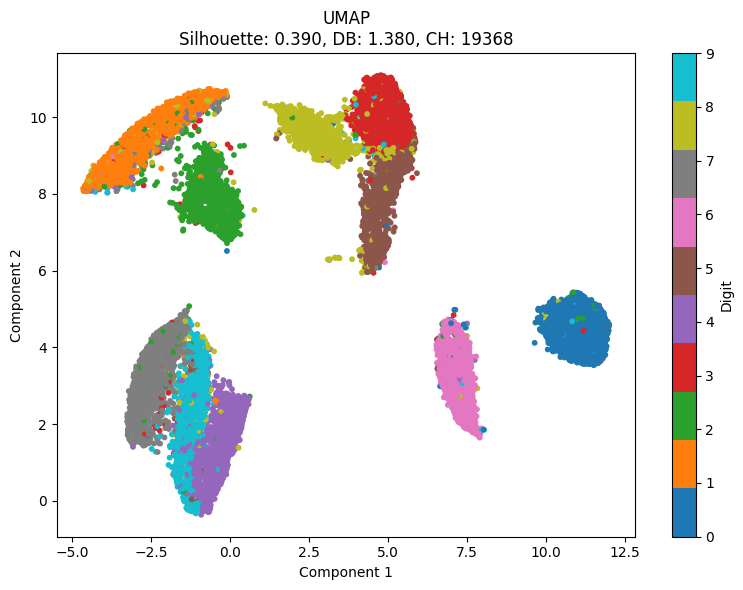

In [26]:
apply_and_visualize('UMAP', methods['UMAP'], X, y, results, metrics)

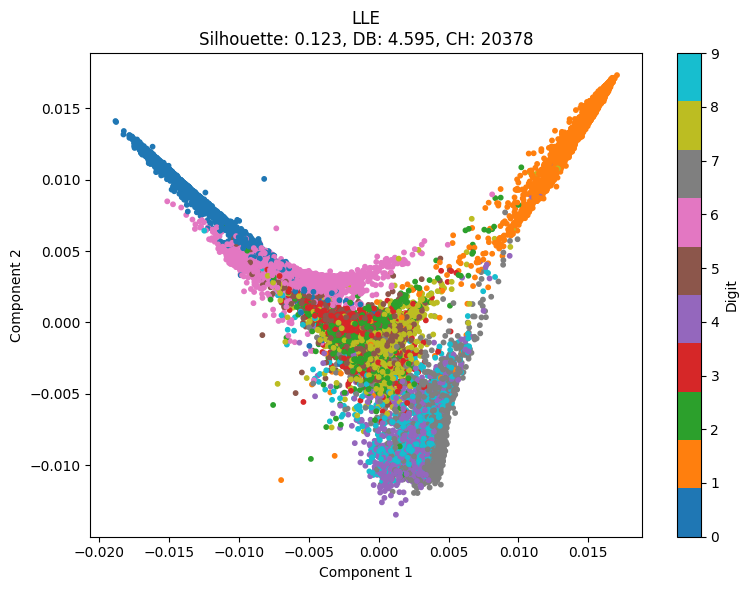

In [27]:
apply_and_visualize('LLE', methods['LLE'], X, y, results, metrics)

In [28]:
metrics_df = pd.DataFrame({
    'Method': methods.keys(),
    'Silhouette Score': metrics['Silhouette'],
    'Davies-Bouldin Index': metrics['Davies-Bouldin'],
    'Calinski-Harabasz Index': metrics['Calinski-Harabasz']
})

metrics_df

Method  Silhouette Score  Davies-Bouldin Index  \
0             PCA          0.018679              6.235715   
1             SVD         -0.031964              6.461202   
2  Randomized SVD         -0.031964              6.461202   
3           t-SNE          0.359155              2.004179   
4            UMAP          0.390217              1.380181   
5             LLE          0.122538              4.594555   

   Calinski-Harabasz Index  
0              3591.238287  
1              1816.687530  
2              1816.687530  
3             13259.419922  
4             19367.560547  
5             20378.261920



# Image compression using SVD

In [29]:
image_paths = ['/content/drive/MyDrive/data/blackWhiteImages/image1.jpeg', '/content/drive/MyDrive/data/blackWhiteImages/image2.jpg', '/content/drive/MyDrive/data/blackWhiteImages/image3.jpeg']

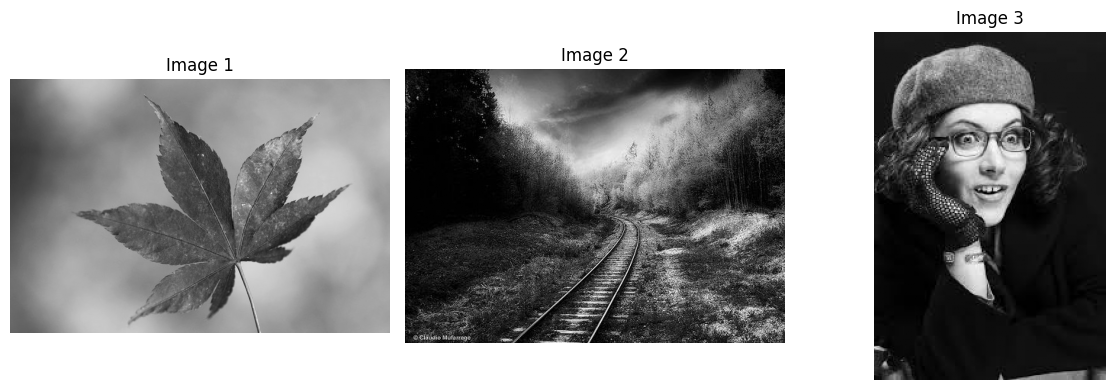

In [30]:
images = []
labels = ['Image 1', 'Image 2', 'Image 3']
for path in image_paths:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img_array = img.astype(float) / 255.0
    images.append(img_array)

plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [41]:
def svd_approximation(image, ranks, label):
    U, s, Vt = np.linalg.svd(image, full_matrices=True)

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(s)+1), s, 'b-o', markersize=5)
    plt.title(f'Spectrum of singular values: {label}')
    plt.xlabel('Rang (i)')
    plt.ylabel('Singular value (σ_i)')
    plt.grid(True)
    plt.show()

    explained_variance = np.cumsum(s**2) / np.sum(s**2)
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(explained_variance)+1), explained_variance, 'r-o', markersize=5)
    plt.title(f'Explained variance: {label}')
    plt.xlabel('Rang (k)')
    plt.ylabel('Proportion of explained variance')
    plt.grid(True)
    plt.axhline(y=0.9, color='gray', linestyle='--', label='90% variances')
    plt.legend()
    plt.show()

    plt.figure(figsize=(15, 6))
    for i, k in enumerate(ranks):
        image_k = U[:, :k] @ np.diag(s[:k]) @ Vt[:k, :]
        image_k = np.clip(image_k, 0, 1)

        plt.subplot(2, 5, i+1)
        plt.imshow(image_k, cmap='gray')
        plt.title(f'Rang {k}')
        plt.axis('off')
    plt.suptitle(f'Reconstruction: {label}')
    plt.tight_layout()
    plt.show()

    return s, explained_variance

In [42]:
ranks = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40]

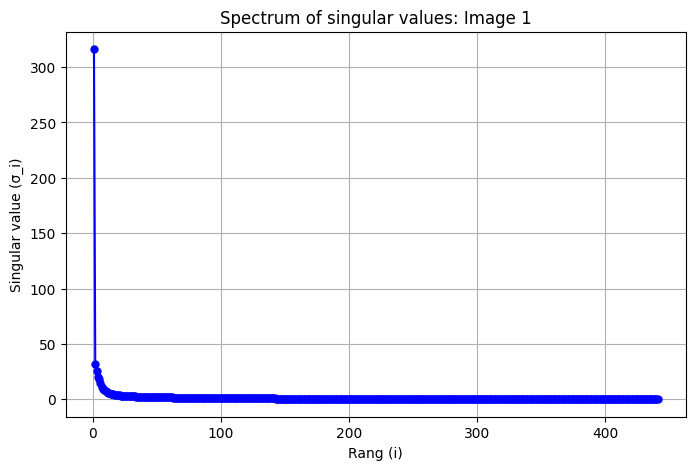

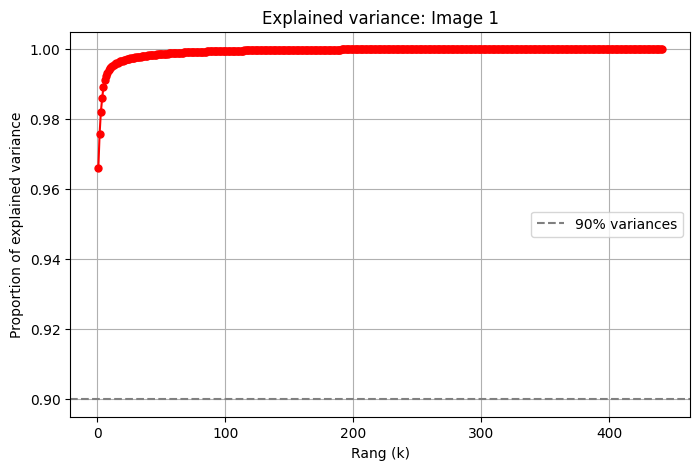

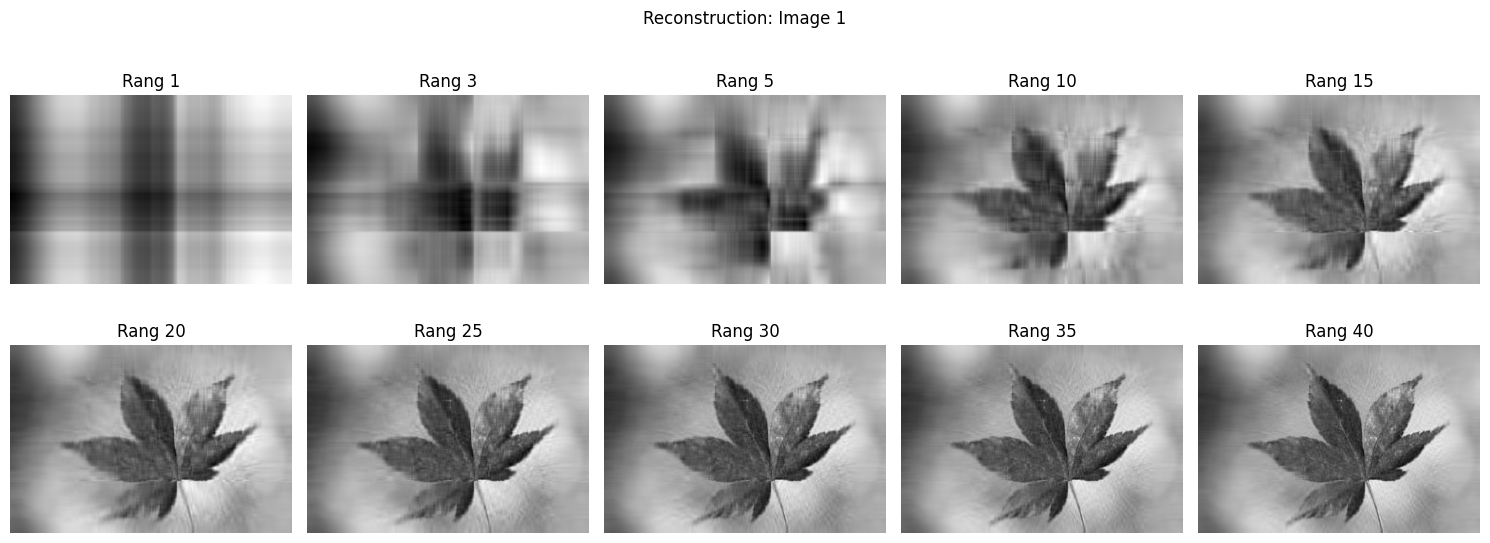

In [43]:
s_0, ev_0 = svd_approximation(images[0], ranks, labels[0])

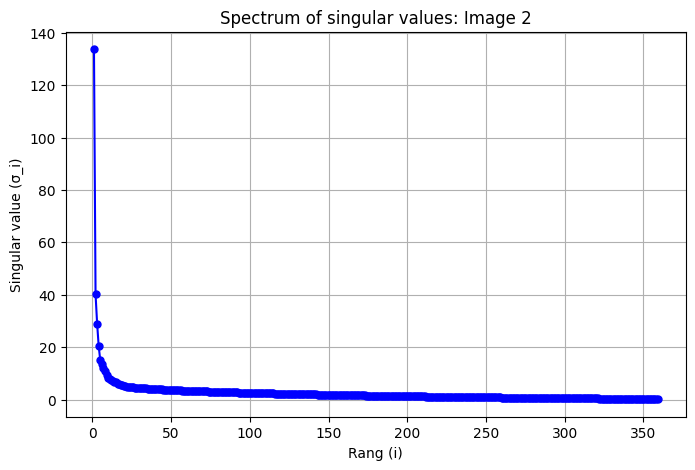

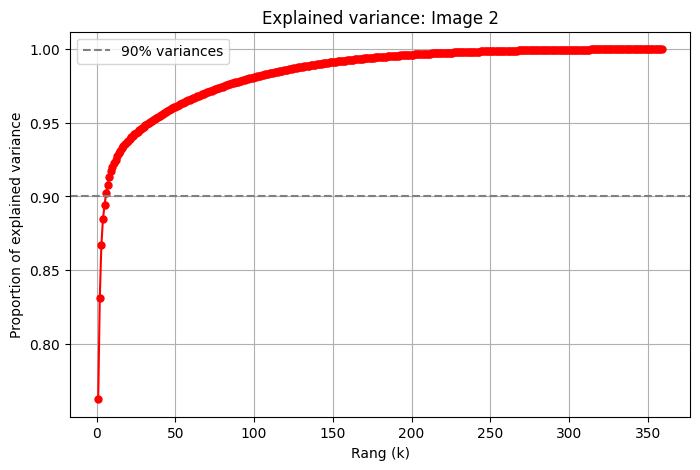

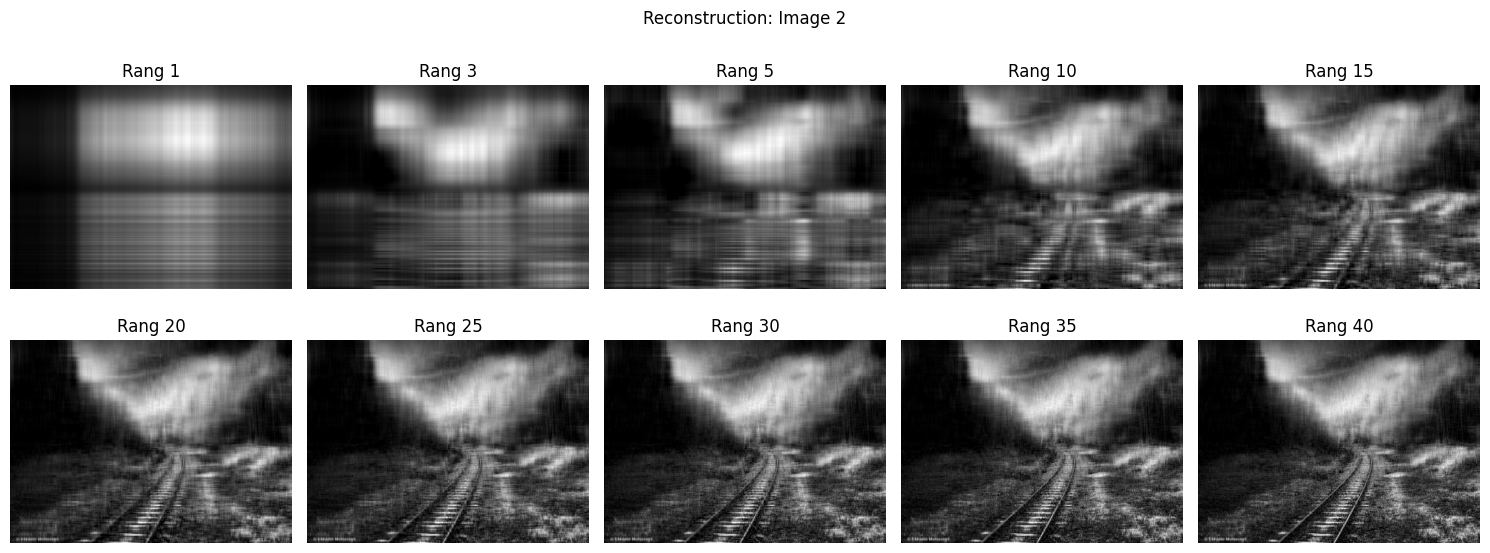

In [44]:
s_1, ev_1 = svd_approximation(images[1], ranks, labels[1])

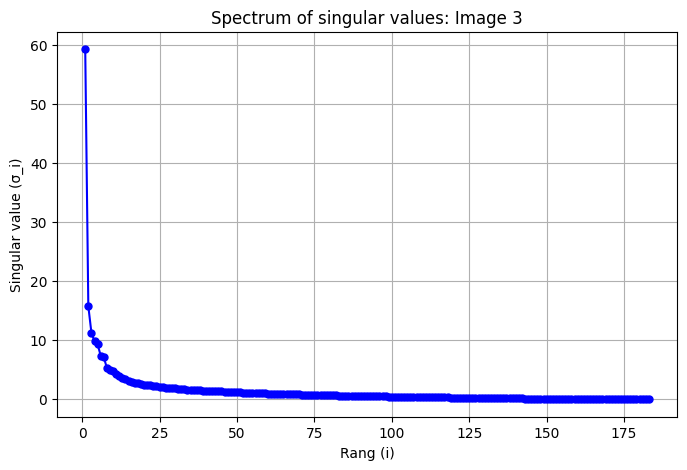

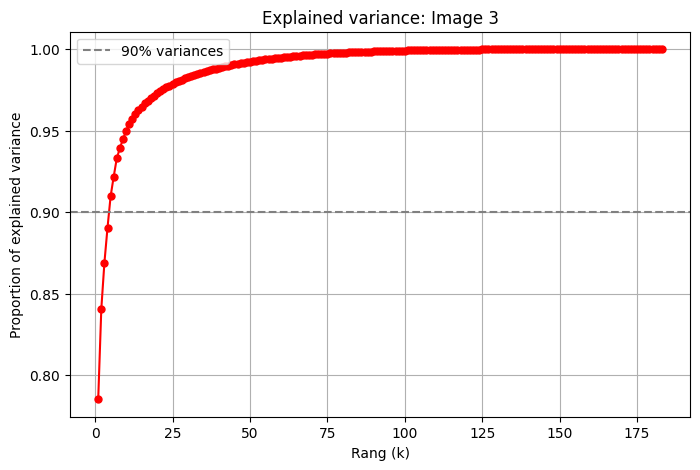

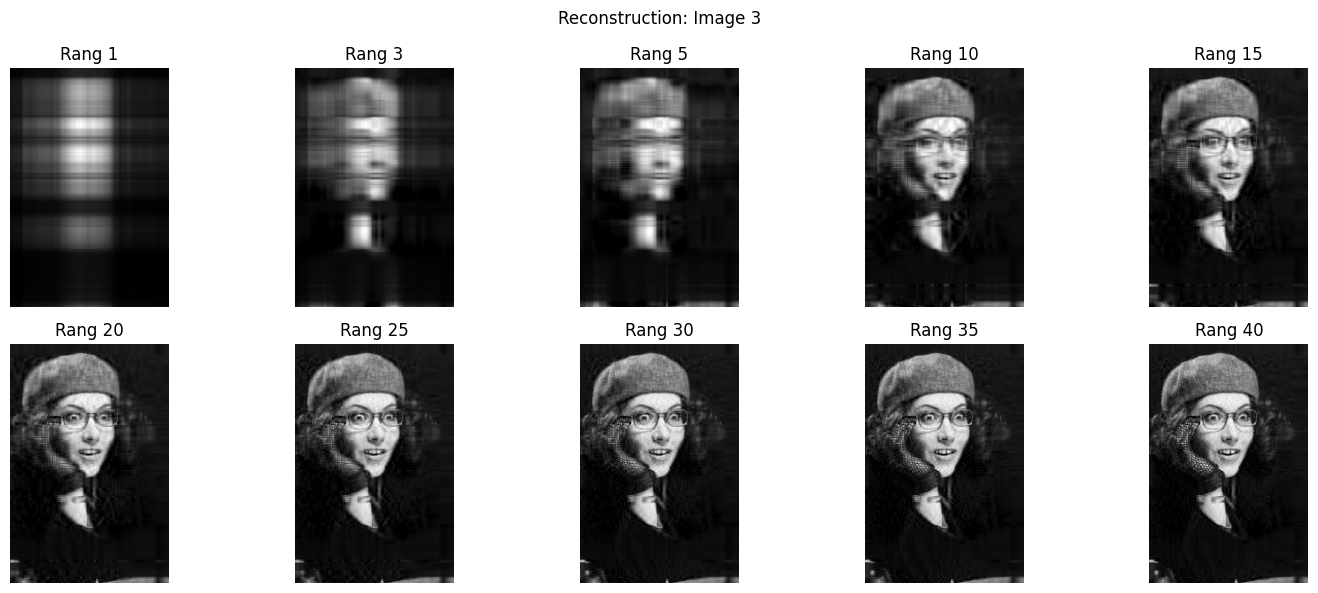

In [45]:
s_2, ev_2 = svd_approximation(images[2], ranks, labels[2])

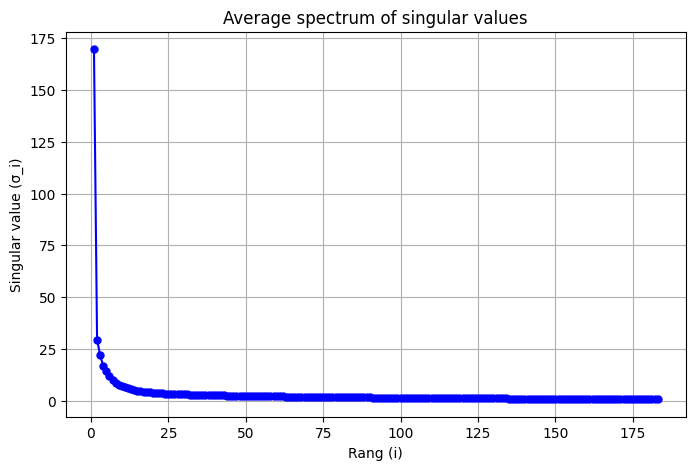

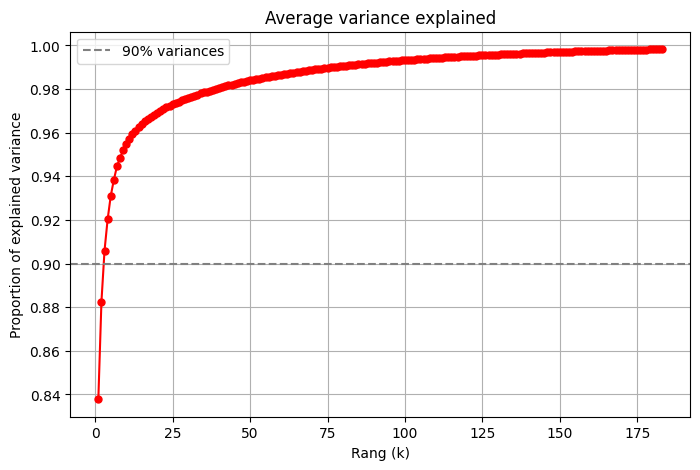

In [46]:
min_len = min(len(s_0), len(s_1), len(s_2))
s_avg = np.mean([s_0[:min_len], s_1[:min_len], s_2[:min_len]], axis=0)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(s_avg)+1), s_avg, 'b-o', markersize=5)
plt.title('Average spectrum of singular values')
plt.xlabel('Rang (i)')
plt.ylabel('Singular value (σ_i)')
plt.grid(True)
plt.show()

ev_avg = np.mean([ev_0[:min_len], ev_1[:min_len], ev_2[:min_len]], axis=0)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(ev_avg)+1), ev_avg, 'r-o', markersize=5)
plt.title('Average variance explained')
plt.xlabel('Rang (k)')
plt.ylabel('Proportion of explained variance')
plt.grid(True)
plt.axhline(y=0.9, color='gray', linestyle='--', label='90% variances')
plt.legend()
plt.show()

**What is explained variance?**

Explained variance is the fraction of the total variation in the image data (pixel intensities) preserved when using the first $ k $ singular values ​​in the SVD. It is calculated as:
$$\text{Explained variance} = \frac{\sum_{i=1}^k \sigma_i^2}{\sum_{i=1}^r \sigma_i^2},$$
where $ \sigma_i $ are singular values, $ r $ is the full rank of the matrix (e.g. 128 for a 128x128 image).
A value of 90% means that the approximation preserves 90% of the information in the original image. This is a measure of the compression quality: the higher the $ k $, the more detail is preserved.

**What does the spectrum of singular values ​​look like?**

The spectrum of singular values ​​($ \sigma_i $) usually shows a rapid decrease in values ​​with increasing index $ i $. The first few values ​​(e.g. 5-10) are large, as they capture the main structures of the image (contours, large shapes). Then the values ​​decrease exponentially or close to it, which indicates a smaller contribution of subsequent modes to details (fine textures). For simple images the decrease is faster, for complex images (with a lot of details) it is slower.

**How many modes are needed for a good image reconstruction?**

The number of modes ($ k $) for a good reconstruction depends on the complexity of the image:

For simple images (e.g. with large monochromatic areas) $ k=10-20 $ is enough, which corresponds to ~80-90% of the explained variance.
For detailed images (with fine textures) $ k=30-50 $ or more may be required (90-95% of the variance).
Typically, an image becomes recognizable at $ k=10–20 $, and almost identical to the original at $ k=50–75 $. Full recovery is achieved at $ k=r $ (e.g. 128 for a 128x128 image).

Visually, a "good" reconstruction is when the main features of the image (shapes, contours) are clear, and minor artifacts are minimal. This often corresponds to 90% of the explained variance.

# Background detection using SVD

In [47]:
cap = cv2.VideoCapture('/content/drive/MyDrive/data/backgroundModelsChallenge/Video_008.avi')
frames = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frames.append(gray.flatten())
cap.release()

In [48]:
A = np.array(frames).T

U, Sigma, Vt = np.linalg.svd(A, full_matrices=False)

k = 1
A_k = U[:, :k] @ np.diag(Sigma[:k]) @ Vt[:k, :]

frame_1 = A_k[:, 0].reshape(gray.shape)

cv2.imwrite('background_frame_1.jpg', frame_1)

True

# Face expression changer

In [49]:
data_dir = '/content/drive/MyDrive/data/trainImagesNastroyenue'
emotions = ['sad', 'happy']
image_size = (128, 128)
max_images_per_category = 500

def load_images(data_dir, emotions, image_size, max_images_per_category):
    X = []
    y = []
    images_per_emotion = {emotion: [] for emotion in emotions}
    for emotion_idx, emotion in enumerate(emotions):
        emotion_dir = os.path.join(data_dir, emotion)
        img_files = [f for f in os.listdir(emotion_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        for img_name in img_files:
            img_path = os.path.join(emotion_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, image_size)
            img_array = img.flatten()
            images_per_emotion[emotion].append(img_array)

    min_images = min(len(images_per_emotion[emotion]) for emotion in emotions)
    n_images = min(min_images, max_images_per_category)
    for emotion_idx, emotion in enumerate(emotions):
        img_list = images_per_emotion[emotion]
        indices = np.random.choice(len(img_list), size=n_images, replace=False)
        X.extend([img_list[i] for i in indices])
        y.extend([emotion_idx] * n_images)

    return np.array(X), np.array(y)

In [50]:
X, y = load_images(data_dir, emotions, image_size, max_images_per_category)

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

sad_mask = y == emotions.index('sad')
happy_mask = y == emotions.index('happy')

## PCA

In [51]:
start_time = time.time()
n_components_pca = 300
pca = PCA(n_components=n_components_pca, random_state=42)
X_reduced_pca = pca.fit_transform(X_normalized)

sad_reduced_pca = X_reduced_pca[sad_mask]
happy_reduced_pca = X_reduced_pca[happy_mask]

mean_sad_pca = np.mean(sad_reduced_pca, axis=0)
mean_happy_pca = np.mean(happy_reduced_pca, axis=0)

delta_pca = mean_happy_pca - mean_sad_pca

sad_example_pca = sad_reduced_pca[0]
happy_transformed_pca = sad_example_pca + delta_pca
pca_happy_reconstructed = pca.inverse_transform(happy_transformed_pca.reshape(1, -1))
pca_happy_reconstructed = scaler.inverse_transform(pca_happy_reconstructed).reshape(image_size)

happy_example_pca = happy_reduced_pca[0]
sad_transformed_pca = happy_example_pca - delta_pca
pca_sad_reconstructed = pca.inverse_transform(sad_transformed_pca.reshape(1, -1))
pca_sad_reconstructed = scaler.inverse_transform(pca_sad_reconstructed).reshape(image_size)

pca_time = time.time() - start_time
print(f"PCA execution time: {pca_time:.2f} s")

PCA execution time: 9.84 s


## SVD

In [52]:
start_time = time.time()
n_components_svd = 300
svd = TruncatedSVD(n_components=n_components_svd, random_state=42)
X_reduced_svd = svd.fit_transform(X_normalized)

sad_reduced_svd = X_reduced_svd[sad_mask]
happy_reduced_svd = X_reduced_svd[happy_mask]

mean_sad_svd = np.mean(sad_reduced_svd, axis=0)
mean_happy_svd = np.mean(happy_reduced_svd, axis=0)

delta_svd = mean_happy_svd - mean_sad_svd

sad_example_svd = sad_reduced_svd[0]
happy_transformed_svd = sad_example_svd + delta_svd
svd_happy_reconstructed = svd.inverse_transform(happy_transformed_svd.reshape(1, -1))
svd_happy_reconstructed = scaler.inverse_transform(svd_happy_reconstructed).reshape(image_size)

happy_example_svd = happy_reduced_svd[0]
sad_transformed_svd = happy_example_svd - delta_svd
svd_sad_reconstructed = svd.inverse_transform(sad_transformed_svd.reshape(1, -1))
svd_sad_reconstructed = scaler.inverse_transform(svd_sad_reconstructed).reshape(image_size)

svd_time = time.time() - start_time
print(f"SVD execution time: {svd_time:.2f} s")

SVD execution time: 9.26 s


## VGG19

In [55]:
start_time = time.time()

X_vgg = []
for img in X:
    img = img.reshape(image_size)
    img = cv2.resize(img, (224, 224))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    X_vgg.append(img_rgb)
X_vgg = np.array(X_vgg) / 255.0

vgg19 = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg19.trainable = False

X_reduced_vgg = vgg19.predict(X_vgg)
X_reduced_vgg = X_reduced_vgg.reshape(X_reduced_vgg.shape[0], -1)

sad_reduced_vgg = X_reduced_vgg[sad_mask]
happy_reduced_vgg = X_reduced_vgg[happy_mask]

mean_sad_vgg = np.mean(sad_reduced_vgg, axis=0)
mean_happy_vgg = np.mean(happy_reduced_vgg, axis=0)
delta_vgg = mean_happy_vgg - mean_sad_vgg

sad_example_vgg = sad_reduced_vgg[0]
happy_transformed_vgg = sad_example_vgg + delta_vgg

happy_example_vgg = happy_reduced_vgg[0]
sad_transformed_vgg = happy_example_vgg - delta_vgg

lr = LinearRegression()
lr.fit(X_reduced_vgg, X_normalized)

vgg_happy_reconstructed = lr.predict(happy_transformed_vgg.reshape(1, -1))
vgg_happy_reconstructed = scaler.inverse_transform(vgg_happy_reconstructed).reshape(image_size)

vgg_sad_reconstructed = lr.predict(sad_transformed_vgg.reshape(1, -1))
vgg_sad_reconstructed = scaler.inverse_transform(vgg_sad_reconstructed).reshape(image_size)

vgg_time = time.time() - start_time
print(f"VGG19 execution time: {vgg_time:.2f} s")

32/32 ━━━━━━━━━━━━━━━━━━━━ 496s 15s/step
VGG19 execution time: 573.56 s


## UMAP

In [56]:
start_time = time.time()
n_components = 5
umap_model = UMAP(n_components=n_components, random_state=42, n_neighbors=5, min_dist=0.3)
X_reduced_umap = umap_model.fit_transform(X_normalized)

sad_mask = y == emotions.index('sad')
happy_mask = y == emotions.index('happy')
sad_reduced_umap = X_reduced_umap[sad_mask]
happy_reduced_umap = X_reduced_umap[happy_mask]
X_sad = X[sad_mask]
X_happy = X[happy_mask]

mean_sad_umap = np.mean(sad_reduced_umap, axis=0)
mean_happy_umap = np.mean(happy_reduced_umap, axis=0)
delta_umap = mean_happy_umap - mean_sad_umap

sad_example_umap = sad_reduced_umap[0]
happy_transformed_umap = sad_example_umap + delta_umap
happy_reconstructed_umap = umap_model.inverse_transform(happy_transformed_umap.reshape(1, -1))
happy_reconstructed_umap = scaler.inverse_transform(happy_reconstructed_umap).reshape(image_size)

happy_example_umap = happy_reduced_umap[0]
sad_transformed_umap = happy_example_umap - delta_umap
sad_reconstructed_umap = umap_model.inverse_transform(sad_transformed_umap.reshape(1, -1))
sad_reconstructed_umap = scaler.inverse_transform(sad_reconstructed_umap).reshape(image_size)

umap_time = time.time() - start_time
print(f"UMAP execution time: {umap_time:.2f} s")

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP execution time: 133.47 s


## Autoencoder

In [57]:
start_time = time.time()
X_normalized_tf = X / 255.0

input_shape = (image_size[0] * image_size[1],)
latent_dim = 128
input_img = tf.keras.layers.Input(shape=input_shape)
encoded = tf.keras.layers.Dense(1024, activation='relu')(input_img)
encoded = tf.keras.layers.Dense(512, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(256, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(latent_dim, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(256, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(512, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(1024, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(input_shape[0], activation='sigmoid')(decoded)

autoencoder = tf.keras.Model(input_img, decoded)
encoder = tf.keras.Model(input_img, encoded)

encoded_input = tf.keras.layers.Input(shape=(latent_dim,))
decoder_layer = autoencoder.layers[-4](encoded_input)
decoder_layer = autoencoder.layers[-3](decoder_layer)
decoder_layer = autoencoder.layers[-2](decoder_layer)
decoder_layer = autoencoder.layers[-1](decoder_layer)
decoder = tf.keras.Model(encoded_input, decoder_layer)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_normalized_tf, X_normalized_tf, epochs=50, batch_size=64, verbose=1)

X_reduced_tf = encoder.predict(X_normalized_tf)

sad_reduced_tf = X_reduced_tf[sad_mask]
happy_reduced_tf = X_reduced_tf[happy_mask]

mean_sad_tf = np.mean(sad_reduced_tf, axis=0)
mean_happy_tf = np.mean(happy_reduced_tf, axis=0)
delta_tf = mean_happy_tf - mean_sad_tf

sad_example_tf = sad_reduced_tf[0]
happy_transformed_tf = sad_example_tf + delta_tf
happy_reconstructed_tf = decoder.predict(happy_transformed_tf.reshape(1, -1)).reshape(image_size)

happy_example_tf = happy_reduced_tf[0]
sad_transformed_tf = happy_example_tf - delta_tf
sad_reconstructed_tf = decoder.predict(sad_transformed_tf.reshape(1, -1)).reshape(image_size)

tf_time = time.time() - start_time
print(f"Autoencoder execution time: {tf_time:.2f} s")

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 637ms/step - loss: 0.0607
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 605ms/step - loss: 0.0548
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 613ms/step - loss: 0.0510
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 625ms/step - loss: 0.0489
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 558ms/step - loss: 0.0473
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 517ms/step - loss: 0.0446
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 609ms/step - loss: 0.0416
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 598ms/step - loss: 0.0407
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 645ms/step - loss: 0.0377
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 659ms/step - loss: 0.0359
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 638ms/step - loss: 0.0360
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 544ms/step - loss: 0.0339
Epoch 13/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 523ms/step - loss: 0.0314
Epoch 14/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 593ms/step - loss: 0.0298
Epoch 15/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 609

## Results

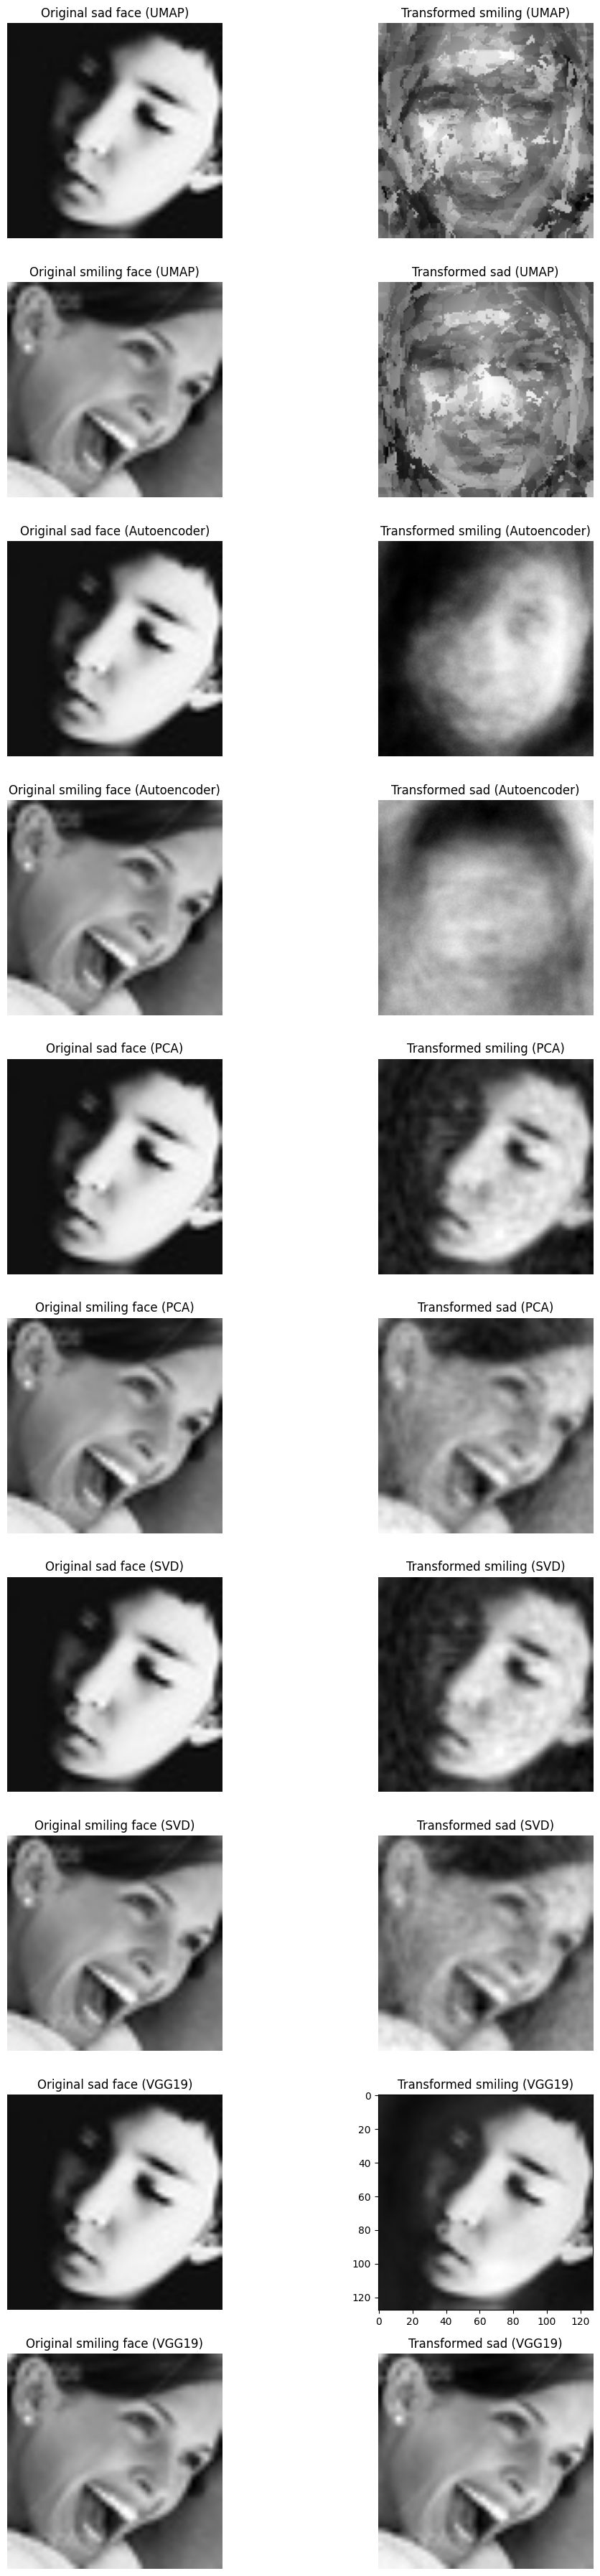

In [58]:
X_sad = X[sad_mask]
X_happy = X[happy_mask]

plt.figure(figsize=(12, 36))

# UMAP
plt.subplot(10, 2, 1)
plt.imshow(X_sad[0].reshape(image_size), cmap='gray')
plt.title('Original sad face (UMAP)')
plt.axis('off')

plt.subplot(10, 2, 2)
plt.imshow(happy_reconstructed_umap, cmap='gray')
plt.title('Transformed smiling (UMAP)')
plt.axis('off')

plt.subplot(10, 2, 3)
plt.imshow(X_happy[0].reshape(image_size), cmap='gray')
plt.title('Original smiling face (UMAP)')
plt.axis('off')

plt.subplot(10, 2, 4)
plt.imshow(sad_reconstructed_umap, cmap='gray')
plt.title('Transformed sad (UMAP)')
plt.axis('off')

# Autoencoder
plt.subplot(10, 2, 5)
plt.imshow(X_sad[0].reshape(image_size), cmap='gray')
plt.title('Original sad face (Autoencoder)')
plt.axis('off')

plt.subplot(10, 2, 6)
plt.imshow(happy_reconstructed_tf, cmap='gray')
plt.title('Transformed smiling (Autoencoder)')
plt.axis('off')

plt.subplot(10, 2, 7)
plt.imshow(X_happy[0].reshape(image_size), cmap='gray')
plt.title('Original smiling face (Autoencoder)')
plt.axis('off')

plt.subplot(10, 2, 8)
plt.imshow(sad_reconstructed_tf, cmap='gray')
plt.title('Transformed sad (Autoencoder)')
plt.axis('off')

# PCA
plt.subplot(10, 2, 9)
plt.imshow(X_sad[0].reshape(image_size), cmap='gray')
plt.title('Original sad face (PCA)')
plt.axis('off')

plt.subplot(10, 2, 10)
plt.imshow(pca_happy_reconstructed, cmap='gray')
plt.title('Transformed smiling (PCA)')
plt.axis('off')

plt.subplot(10, 2, 11)
plt.imshow(X_happy[0].reshape(image_size), cmap='gray')
plt.title('Original smiling face (PCA)')
plt.axis('off')

plt.subplot(10, 2, 12)
plt.imshow(pca_sad_reconstructed, cmap='gray')
plt.title('Transformed sad (PCA)')
plt.axis('off')

# SVD
plt.subplot(10, 2, 13)
plt.imshow(X_sad[0].reshape(image_size), cmap='gray')
plt.title('Original sad face (SVD)')
plt.axis('off')

plt.subplot(10, 2, 14)
plt.imshow(svd_happy_reconstructed, cmap='gray')
plt.title('Transformed smiling (SVD)')
plt.axis('off')

plt.subplot(10, 2, 15)
plt.imshow(X_happy[0].reshape(image_size), cmap='gray')
plt.title('Original smiling face (SVD)')
plt.axis('off')

plt.subplot(10, 2, 16)
plt.imshow(svd_sad_reconstructed, cmap='gray')
plt.title('Transformed sad (SVD)')
plt.axis('off')

# VGG19
plt.subplot(10, 2, 17)
plt.imshow(X_sad[0].reshape(image_size), cmap='gray')
plt.title('Original sad face (VGG19)')
plt.axis('off')

plt.subplot(10, 2, 18)
plt.imshow(vgg_happy_reconstructed, cmap='gray')
plt.title('Transformed smiling (VGG19)')

plt.subplot(10, 2, 19)
plt.imshow(X_happy[0].reshape(image_size), cmap='gray')
plt.title('Original smiling face (VGG19)')
plt.axis('off')

plt.subplot(10, 2, 20)
plt.imshow(vgg_sad_reconstructed, cmap='gray')
plt.title('Transformed sad (VGG19)')
plt.axis('off')

plt.tight_layout()
plt.show()